In [1]:
# General Idea:
# /content/gdrive/My Drive/Colab Notebooks/

# Plan
# 1. Add Background to Image dependent on image size (choose from x different backgrounds)
# 2. Add some more distortions
# 3. Rotate and sheer image
# 4. Rescale images to fixed size.
# 5. Write as generator
# 6. Write CNN which predicts 2 angles

In [ ]:
# colab specific stuff
!pip install pillow
!pip install --upgrade imgaug
!pip install -U -q PyDrive

In [2]:
from PIL import Image
import random
import numpy as np
import cv2
import os

import imgaug as ia
print(ia.__version__)
from imgaug import augmenters as iaa

%matplotlib inline
from matplotlib import pyplot as plt

0.2.7


# Get Data

In [3]:
input_data_folder = "invoice_img_data"
background_img_folder = "background_img"

In [2]:
# https://mikulskibartosz.name/how-to-load-data-from-google-drive-to-pandas-running-in-google-colaboratory-a7f6a033c997
# nali.org/load-google-drive-csv-panda-dataframe-google-colab/
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ModuleNotFoundError: No module named 'pydrive'

In [4]:
drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance
file_list = drive.ListFile({'q': "'1MI8PBiqNT-o6m0xYV8JYHUkqaqfTKkz2' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))
  
invoice_img_folder_id = "1lf4Ln_P_bFI5ZqZL4Cfr5-uVFPHoUjj5"
background_img_folder_id = "1Gr9uJWxANEapNSovT8cP--QUzWeTv5Pw"

title: invoice_img_data, id: 1lf4Ln_P_bFI5ZqZL4Cfr5-uVFPHoUjj5
title: background_img, id: 1Gr9uJWxANEapNSovT8cP--QUzWeTv5Pw
title: gen_invoices_labels_100k.csv, id: 1727tj-xC0LJUZ77N2AdIyQWNJX7jKj1x


In [0]:
def create_folder_get_data(folder_id, folder_name):
  # create data folder
  try:
      os.mkdir(folder_name)
  except FileExistsError:
      print("%s folder already created!" % folder_name)

  os.chdir(folder_name)
  
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  file_list = [x for x in file_list if "label" not in x['title']]#[:30]

  for i, file1 in enumerate(sorted(file_list, key = lambda x: x['title'])):
      print('Downloading {} from GDrive ({}/{})'.format(file1['title'], i, len(file_list)))
      file1.GetContentFile(file1['title'])
      
  os.chdir("..")

In [0]:
# create_folder_get_data(invoice_img_folder_id, input_data_folder)

In [0]:
# create_folder_get_data(background_img_folder_id, background_img_folder)

In [8]:
!ls invoice_img_data

out_0.png    out_145.png  out_190.png  out_235.png  out_280.png  out_55.png
out_100.png  out_146.png  out_191.png  out_236.png  out_281.png  out_56.png
out_101.png  out_147.png  out_192.png  out_237.png  out_282.png  out_57.png
out_102.png  out_148.png  out_193.png  out_238.png  out_283.png  out_58.png
out_103.png  out_149.png  out_194.png  out_239.png  out_284.png  out_59.png
out_104.png  out_14.png   out_195.png  out_23.png   out_285.png  out_5.png
out_105.png  out_150.png  out_196.png  out_240.png  out_286.png  out_60.png
out_106.png  out_151.png  out_197.png  out_241.png  out_287.png  out_61.png
out_107.png  out_152.png  out_198.png  out_242.png  out_288.png  out_62.png
out_108.png  out_153.png  out_199.png  out_243.png  out_289.png  out_63.png
out_109.png  out_154.png  out_19.png   out_244.png  out_28.png	 out_64.png
out_10.png   out_155.png  out_1.png    out_245.png  out_290.png  out_65.png
out_110.png  out_156.png  out_200.png  out_246.png  out_291.png  out_66.png
out_111.png  o

In [9]:
!ls background_img

1538846.jpg
33971803-potted-grass-flower-over-wooden-table-background-with-copy-space.jpg
43581859-succulent-in-pot-wooden-table-background-with-copy-space.jpg
79876024-abstract-surface-white-wood-table-texture-background-close-up-of-dark-rustic-wall-made-of-white-wood.jpg
81915338-abstract-rustic-surface-white-wood-table-texture-background-close-up-of-rustic-wall-made-of-white-wo.jpg
93268346-white-background-wooden-table-surface-texture-planks-close-up.jpg
abstract-light-grey-background-vector-13747865.jpg
Dark-Grey-Background-Texture-10.jpg
f50524ee5f161f437400aaf215c9e12f.jpg
hazelnut-falling-on-a-wooden-table-on-a-black-background-slow-motion-close-up_rahktoix__F0000.png
images1.jpg
images2.jpg
images.jpg
index1.png
index.jpg
mobile-phone-with-blank-screen-on-wooden-table-background-top-view-with-copy-space_1253-984.jpg
pexels-photo-242236.jpeg
pouring-of-lentils-on-white-background-this-video-was-shoot-using-custom-light-set-up-with-additional-custom-build-underneath-light-system

In [63]:
max_foreground_size = 300
scaler = 2
max_rotation = 45
max_shear = 0

# Augmentation

In [64]:
def add_background_img(foreground, background, max_foreground_size, scaler):
    width = foreground.size[0]
    height = foreground.size[1]
#     print(width, height)

    if(width > height):
        max_size = int(width*scaler)
    else:
        max_size = int(height*scaler)

    foreground = foreground.resize((int(width), int(height)), Image.ANTIALIAS)
    background = background.resize((max_size, max_size), Image.ANTIALIAS)

    margin_w = int((background.size[0]-foreground.size[0])/2)
    margin_h = int((background.size[1]-foreground.size[1])/2)

    # foreground.show()
    background.paste(foreground, (margin_w, margin_h))
#     background.show()

    return background

In [69]:
def augment_img(foreground, background, max_foreground_size, scaler, max_rotation, max_shear):
    # load image with background
    open_cv_image = np.array(add_background_img(foreground, background, max_foreground_size, scaler).convert('RGB'))

    # Convert RGB to BGR
    open_cv_image = open_cv_image[:, :, ::-1].copy() 

    # define augmentations
    rotation = random.randint(-max_rotation,max_rotation)
    shear = random.randint(-max_shear, max_shear)

    # 2. Add some more distortions
#     blur_aug = ia.augmenters.blur.MotionBlur(k=(3,4), angle=(0, 360), direction=(-1.0, 1.0))
    
    # 3. Rotate and sheer image
    rotate_aug = ia.augmenters.geometric.Affine(rotate=rotation)
    shear_aug = ia.augmenters.geometric.Affine(shear=shear)
    
    # exectue augmentation
    new_img = rotate_aug.augment_image(open_cv_image)
#     new_img = blur_aug.augment_image(new_img)
    new_img = shear_aug.augment_image(new_img)

    # show
    img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
#     img.show()

    # crop image
    rand_scaler = scaler/1.3 #*random.uniform(0.7,1.3)
#     print("rand_scaler", rand_scaler)
    crop_side_percentage = (rand_scaler-1)/(2*rand_scaler)

    area = (
        img.size[0]*crop_side_percentage, # width left
        img.size[1]*crop_side_percentage, # height top
        img.size[0]*(1-crop_side_percentage), # width right
        img.size[1]*(1-crop_side_percentage), # height bottom
    )
    cropped_img = img.crop(area)
#     cropped_img.show()
    
    return cropped_img, rotation, shear

In [70]:
def img_show(img, figsz, cv=False):
    fig=plt.figure(figsize=(figsz, figsz), dpi= 40, facecolor='w', edgecolor='k')
    if(cv): # convert to cv2 if image is not cv2
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    return None

In [71]:
input_img_names = [x for x in os.listdir(input_data_folder) if "_label" not in x and ".png" in x]
background_img_names = [
    x for x in os.listdir(background_img_folder) if "_label" not in x and ".png" in x or ".jpg" in x or ".jpeg" in x]

7 0


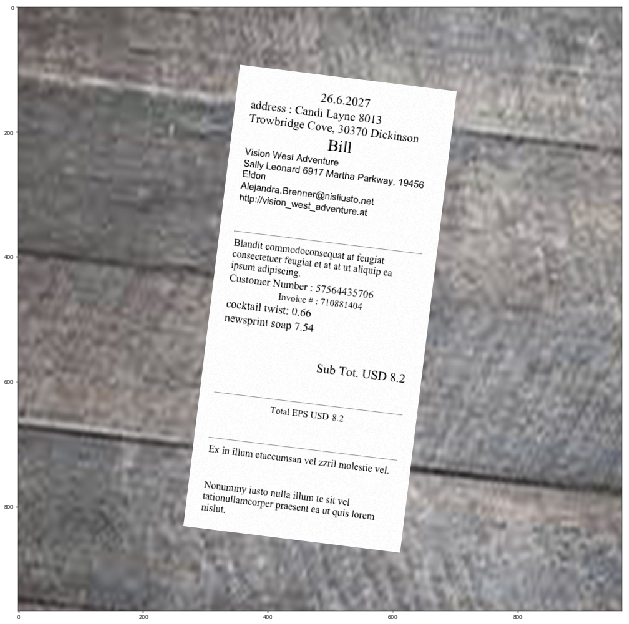

In [73]:
# test augmentation
img_name = random.choice(input_img_names)
background_name = random.choice(background_img_names)

foreground = Image.open(os.path.join(input_data_folder, img_name))
background = Image.open(os.path.join(background_img_folder, background_name))

curr_img, rotation, shear = augment_img(foreground, background, max_foreground_size,
                                        scaler, max_rotation, max_shear)
img_show(curr_img, 20)
print(rotation, shear)

In [74]:
len(input_img_names), len(background_img_names)

(110, 23)

# Training

In [11]:
# !!pip uninstall torch
!pip install -q torch==1.0.0 torchvision
!pip install wandb

In [75]:
from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from numpy import argmax

import torch
print(torch.__version__)
from torch import nn
import torch.backends.cudnn as cudnn

# https://stackoverflow.com/questions/42480111/model-summary-in-pytorch
# from torchsummary import summary

# https://github.com/lanpa/tensorboardX
# from tensorboardX import SummaryWriter
# writer = SummaryWriter("logs/image_rotation")

import wandb

1.0.0


In [76]:
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [77]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout, ksize, padd):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=ksize, padding=padd, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [78]:
class conv_max_step(nn.Module):
    def __init__(self, nin, nout, ksize, padd):
        super(conv_max_step, self).__init__()
        self.conv = depthwise_separable_conv(nin, nout, ksize, padd)
        self.batchn = nn.BatchNorm2d(nout)
        self.tanh = nn.ReLU()
        self.maxp = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchn(x)
        x = self.tanh(x)
        x = self.maxp(x)
        return x

In [79]:
class Model(nn.Module):
    def __init__(self, max_img_size, nchannel, nclasses_1, nclasses_2):
        super(Model, self).__init__()

        nin = nchannel
        nout = int(nin*2)
        self.cm1 = conv_max_step(nin, nout, 7, 3)
        max_img_size = max_img_size/2

        nin = nout
        nout = int(nin*2)
        self.cm2 = conv_max_step(nin, nout, 3, 1)
        max_img_size = max_img_size/2

        nin = nout
        nout = int(nin*2)
        self.cm3 = conv_max_step(nin, nout, 3, 1)
        max_img_size = max_img_size/2

        nin = nout
        nout = int(nin*2)
        self.cm4 = conv_max_step(nin, nout, 3, 1)
        max_img_size = int(max_img_size/2)

        self.lin_dim = nout*max_img_size*max_img_size
        self.fc1 = nn.Linear(in_features=self.lin_dim, out_features=nclasses_1)
        self.fc2 = nn.Linear(in_features=self.lin_dim, out_features=nclasses_2)
        self.softm1 = nn.LogSoftmax(dim=1)
        self.softm2 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.cm1(x)
        x = self.cm2(x)
        x = self.cm3(x)
        x = self.cm4(x)
        x = x.view(-1, self.lin_dim)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        out1 = self.softm1(x1)
        out2 = self.softm2(x2)
       
        return out1, out2

In [80]:
def encoder_func(encode, arr):
  integer_encoded = [encode[x] for x in arr]
#   print(integer_encoded)

  # one hot encode
  onehot_encoded = list()
  for value in integer_encoded:
    item = [0 for _ in range(len(encode))]
    item[value] = 1
    onehot_encoded.append(item)
#     print(sum(item), item)

  return onehot_encoded

In [252]:
def training_data_generator(input_img_names, background_img_names, itr, batch_size, rot_to_int, she_to_int, device):
    inpu = []
    rotation = []
    shear = []

    # put into generator function for evaluation
    for img_name in input_img_names[itr*batch_size:(itr+1)*batch_size]:
        background_name = random.choice(background_img_names)

#         print(os.path.join(input_data_folder, img_name))
        foreground = Image.open(os.path.join(input_data_folder, img_name))
#         print(os.path.join(background_img_folder, background_name))
        background = Image.open(os.path.join(background_img_folder, background_name))

        curr_img, rot, she = augment_img(foreground, background, max_foreground_size,
                                         scaler, max_rotation, max_shear)

        curr_img = curr_img.resize((max_img_size, max_img_size), Image.ANTIALIAS)
        curr_img = np.array(curr_img)

        inpu.append(curr_img)
        rotation.append(rot)
        shear.append(she)

#     img_show(inpu[0], 12)
    # move channel to second index position
    inpu = np.swapaxes(np.array(inpu), 3, -3)
#     img_show(np.swapaxes(np.array(inpu), 1, 3)[0], 12)
    X = torch.tensor(inpu/255).float().to(device)
#     img_show(np.swapaxes(X[0].detach().numpy(), 2, -3), 12)

    rotation_enc = encoder_func(rot_to_int, rotation)
    rotation_enc = np.array(rotation_enc)
    y1 = torch.from_numpy(rotation_enc).float().to(device)

    shear_enc = encoder_func(she_to_int, shear)
    shear_enc = np.array(shear_enc)
    y2 = torch.from_numpy(shear_enc).float().to(device)

    return X, y1, y2

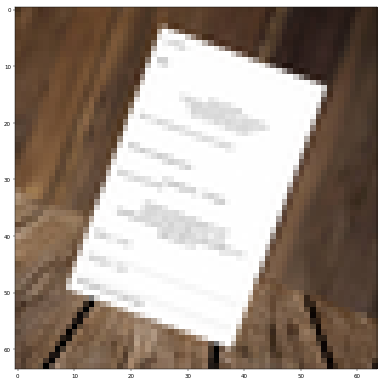

In [253]:
# test generator
X, y1, y2 = training_data_generator(input_img_names, background_img_names, itr,
                                    batch_size, rot_to_int, she_to_int, device)
img_show(np.swapaxes(X[0].detach().numpy(), 2, -3), 12)

In [153]:
# preperation for saving model
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [146]:
max_epochs = 1
batch_size = 16
learning_rate = 1e-5

n_batches =  int(np.ceil(len(input_img_names)/batch_size))

print(max_epochs, batch_size, n_batches)

rot_to_int = dict((c, i) for i, c in enumerate(range(-max_rotation,max_rotation+1)))
she_to_int = dict((c, i) for i, c in enumerate(range(-max_shear,max_shear+1)))

max_img_size = 64
inp_channels = 3
nclasses_1 = max_rotation*2+1
nclasses_2 = max_shear*2+1

1 16 7


In [83]:
# test if GPU is being used
cudnn.benchmark = True

# model
model = Model(max_img_size, inp_channels, nclasses_1, nclasses_2)
model.to(device)
# loss
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

wandb.init()

W&B Run: https://app.wandb.ai/charistoph/invoice_ocr/runs/lt2ggtkr
Call `%%wandb` in the cell containing your training loop to display live results.


W&B Run: https://app.wandb.ai/charistoph/invoice_ocr/runs/lt2ggtkr

In [21]:
for epoch in tqdm(range(max_epochs)):
#     print("epoch: %i" % epoch)
    for itr in range(n_batches):
        # get training data from generator
        X, y1, y2 = training_data_generator(input_img_names, background_img_names, itr,
                                            batch_size, rot_to_int, she_to_int, device)
#         print(X.shape, y1.shape, y2.shape)

        # Forward pass: compute predicted y by passing x to the model.
        y_pred1, y_pred2 = model.forward(X)

        # Compute and print loss.
        loss = criterion(y_pred1, torch.max(y1.long(), 1)[1]) + criterion(y_pred2, torch.max(y2.long(), 1)[1])

        # Zero the gradients before running the backward pass.
        model.zero_grad()

        # Backward pass: compute gradient of the loss.
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        print(itr, loss.item())
    
    wandb.log({'loss': loss.item()})
    print(epoch, loss.item())
#     writer.add_scalar("total_loss", loss.item(), epoch)

  0%|          | 0/1 [00:00<?, ?it/s]

0 8.752202987670898
1 8.879217147827148
2 8.662802696228027
3 8.862398147583008
4 8.539456367492676
5 8.513696670532227
6 8.813323974609375


100%|██████████| 1/1 [00:24<00:00, 24.53s/it]

0 8.813323974609375


# Save Model

In [0]:
model_folder = "/content/gdrive/My Drive/Colab Notebooks/models"

# create data folder
try:
    os.mkdir(model_folder)
except:
    print("%s folder already created!" % model_folder)

torch.save(model, "%s/image_rotation.pt" % model_folder)

# Sudo Inference

In [254]:
itr = 0
batch_size = 8
X, y1, y2 = training_data_generator(input_img_names, background_img_names, itr,
                                    batch_size, rot_to_int, she_to_int, device)

y_pred1, y_pred2 = model.forward(X)

In [255]:
len(y_pred1[0]), len(y_pred2[0])

(91, 1)

In [259]:
def correct_image(input_img, shear, rotation):
    shear_aug_ = ia.augmenters.geometric.Affine(shear=-shear)
    rotate_aug_ = ia.augmenters.geometric.Affine(rotate=-rotation)

    input_img = Image.fromarray(input_img)
    reverse_img = np.array(input_img.convert('RGB'))

    # Convert RGB to BGR
    reverse_img = reverse_img[:, :, ::-1].copy()

    # reverse augmentation
    reverse_img = shear_aug_.augment_image(reverse_img)
    reverse_img = rotate_aug_.augment_image(reverse_img)

    # show
    img = cv2.cvtColor(reverse_img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    
    return img

(numpy.ndarray, (64, 64, 3))

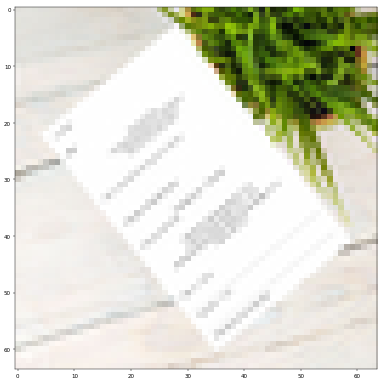

In [285]:
i = 0
curr_rotation = np.argmax(y_pred1[i].detach().numpy())-max_rotation
curr_shear = np.argmax(y_pred2[i].detach().numpy())-max_shear

# corr_img = correct_image(np.swapaxes(X[i].detach().numpy(), 2, -3), curr_shear, curr_rotation)
# img_show(corr_img)
rotation = curr_rotation
shear = curr_shear

curr_img = np.swapaxes(X[i].detach().numpy(), 2, -3)
img_show(curr_img, 12)
type(curr_img), curr_img.shape

In [286]:
shear_aug_ = ia.augmenters.geometric.Affine(shear=-shear)
rotate_aug_ = ia.augmenters.geometric.Affine(rotate=-rotation)

In [287]:
curr_img = Image.fromarray(curr_img.astype('uint8'))
reverse_img = np.array(curr_img.convert('RGB'))

# Convert RGB to BGR
reverse_img = reverse_img[:, :, ::-1].copy()

# reverse augmentation
reverse_img = shear_aug_.augment_image(reverse_img)
reverse_img = rotate_aug_.augment_image(reverse_img)

# show
img = cv2.cvtColor(reverse_img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
img.show()

In [ ]:
# finish showing correctly rotated image (inference)

In [0]:
# load image with background
open_cv_image = np.array(add_background_img(foreground, background, max_foreground_size, scaler).convert('RGB'))

# Convert RGB to BGR
open_cv_image = open_cv_image[:, :, ::-1].copy() 

# augment image (rotate)
# define rotation
rotation = random.uniform(-85,85)
shear = random.uniform(-10,10)
# aug = iaa.Affine(rotate=45) # rotation

# rotate_aug = ia.augmenters.geometric.Affine(rotate=rotation)
# shear_aug = ia.augmenters.geometric.Affine(shear=shear)

# exectue augmentation
# new_img = rotate_aug.augment_image(open_cv_image)
# new_img = shear_aug.augment_image(new_img)

new_img = blur.augment_image(open_cv_image)

# show
img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
img.show()